In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
# Index and import the data
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y')
data = pd.read_csv('train.csv', index_col = 'Year', date_parser=dateparse)
print (data.head())
print ('\n Data Types:')
print (data.dtypes)

            Natural_gas_consumption           GDP  Total_population  \
Year                                                                  
1970-01-01                      3.0  9.150621e+10             82992   
1971-01-01                      3.9  9.856202e+10             85229   
1972-01-01                      5.0  1.120000e+11             87177   
1973-01-01                      6.2  1.370000e+11             89211   
1974-01-01                      7.8  1.420000e+11             90859   

            Urbanization_rate  
Year                           
1970-01-01             17.400  
1971-01-01             17.292  
1972-01-01             17.184  
1973-01-01             17.184  
1974-01-01             17.292  

 Data Types:
Natural_gas_consumption    float64
GDP                        float64
Total_population             int64
Urbanization_rate          float64
dtype: object


In [3]:
data.index

DatetimeIndex(['1970-01-01', '1971-01-01', '1972-01-01', '1973-01-01',
               '1974-01-01', '1975-01-01', '1976-01-01', '1977-01-01',
               '1978-01-01', '1979-01-01', '1980-01-01', '1981-01-01',
               '1982-01-01', '1983-01-01', '1984-01-01', '1985-01-01',
               '1986-01-01', '1987-01-01', '1988-01-01', '1989-01-01',
               '1990-01-01', '1991-01-01', '1992-01-01', '1993-01-01',
               '1994-01-01', '1995-01-01', '1996-01-01', '1997-01-01',
               '1998-01-01', '1999-01-01', '2000-01-01', '2001-01-01',
               '2002-01-01', '2003-01-01', '2004-01-01', '2005-01-01',
               '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01'],
              dtype='datetime64[ns]', name='Year', freq=None)

In [4]:
ts = data['Natural_gas_consumption']
ts.head(10)

Year
1970-01-01     3.0
1971-01-01     3.9
1972-01-01     5.0
1973-01-01     6.2
1974-01-01     7.8
1975-01-01     9.1
1976-01-01    10.4
1977-01-01    12.5
1978-01-01    14.2
1979-01-01    15.0
Name: Natural_gas_consumption, dtype: float64

In [5]:
# To specify the entire range --> Is this necessary?
# ts['1970-01-01':'2015-01-01']

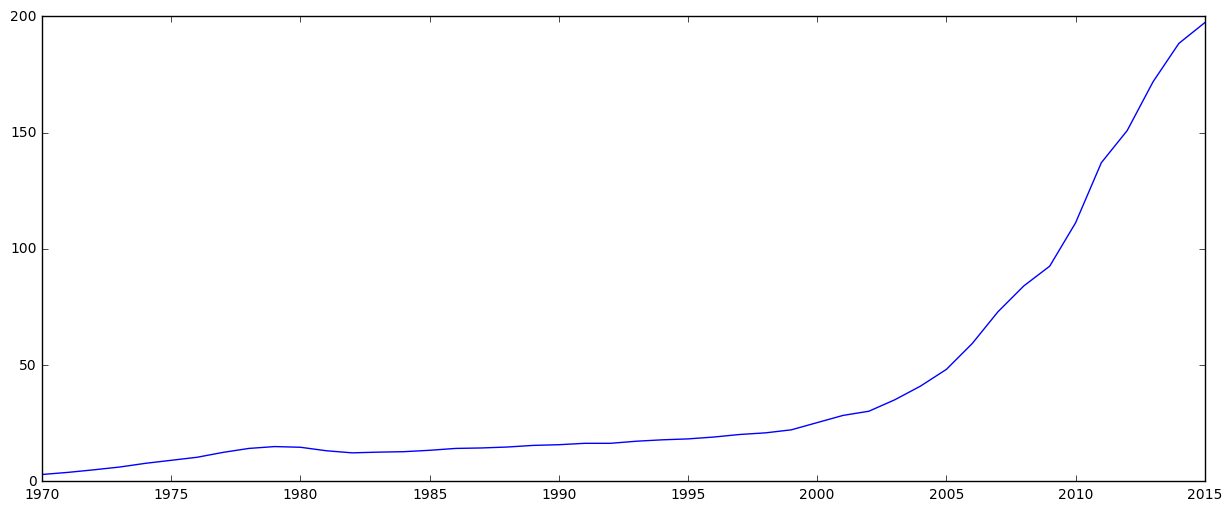

In [6]:
plt.plot(ts)

In [7]:
# Clearly, it is not stationary above
# But, just to be certain, let's try the Dickey-Fuller test below:

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

C:\Users\LYJ\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\LYJ\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


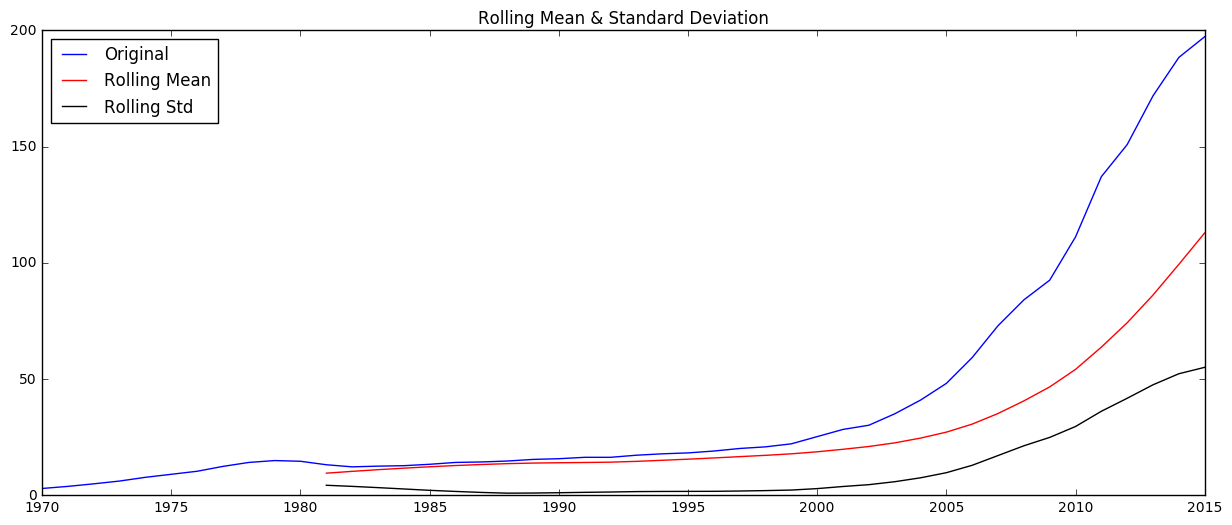

Results of Dickey-Fuller Test:
Test Statistic                 -0.080800
p-value                         0.951318
#Lags Used                     10.000000
Number of Observations Used    35.000000
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
Critical Value (1%)            -3.632743
dtype: float64


In [8]:
test_stationarity(ts)

How to interpret the results of Dickey-Fuller test:
- Test Statistic <= Critical Value --> the series is stationary (i.e. reject the null hypothesis that it is non-stationary)
- Test Statistic > Critical Value --> the series is non-stationary (i.e. accept the null hypothesis that it is non-stationry)

_The above result shows that the series is not stationary._

### Estimating & Eliminating Trends

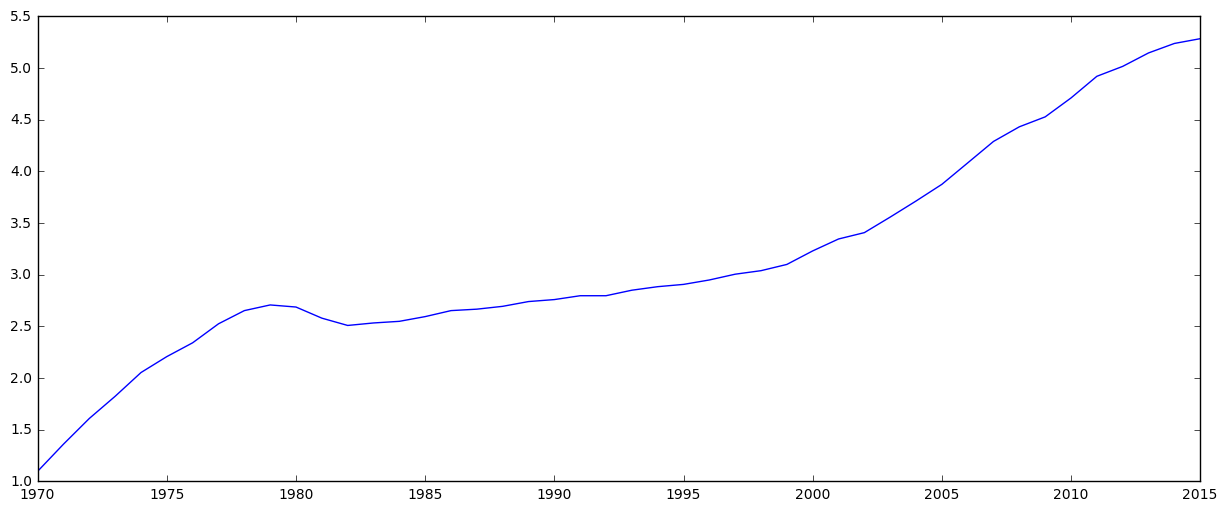

In [9]:
# One of the first tricks to reduce trend is transformation.
# Since we can clearly see that there is a positive trend,
# apply transformation which penalizes higher values more than smaller values.
# e.g. log, square root, cube root, etc. 
ts_log = np.log(ts)
plt.plot(ts_log)

Now, I will use some techniques to estimate or model the trend and then remove it from the series. There are many ways of doing this such as aggregation, smoothing, polynomial fitting, etc. First, used the smoothing (taking rolling averages/estimates, i.e. considering the past few instances) below.

C:\Users\LYJ\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()


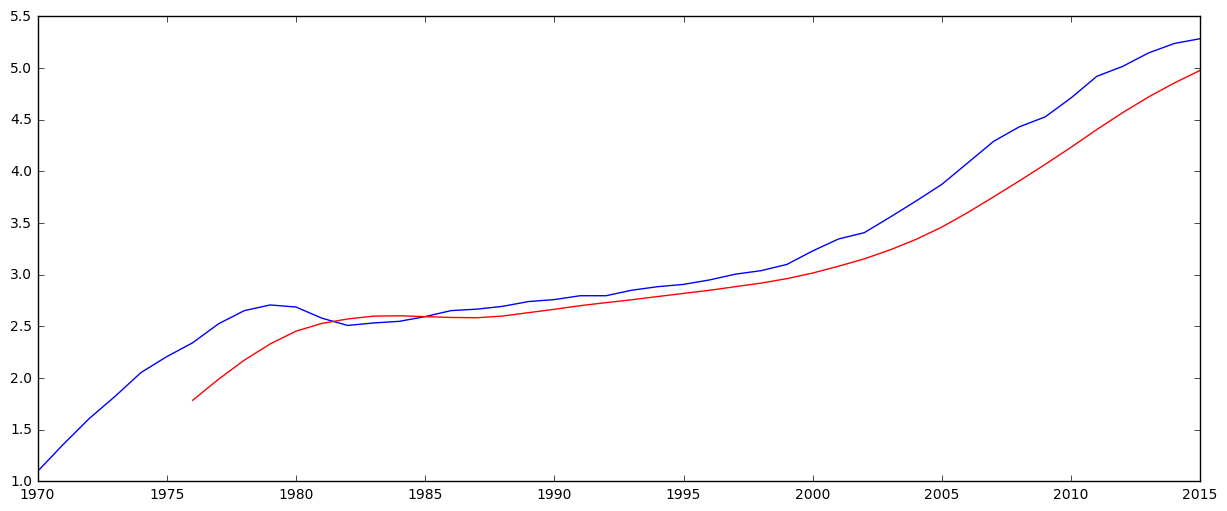

In [22]:
# Moving average
moving_avg = pd.rolling_mean(ts_log,7)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

The red line shows the rolling mean. Now, subtract this from the original series. Note that since I took average of the last 7 values, rolling mean is not defined for the first 6 values. This can be observed as follows:

In [23]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(7)

Year
1970-01-01         NaN
1971-01-01         NaN
1972-01-01         NaN
1973-01-01         NaN
1974-01-01         NaN
1975-01-01         NaN
1976-01-01    0.556409
Name: Natural_gas_consumption, dtype: float64

C:\Users\LYJ\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\LYJ\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


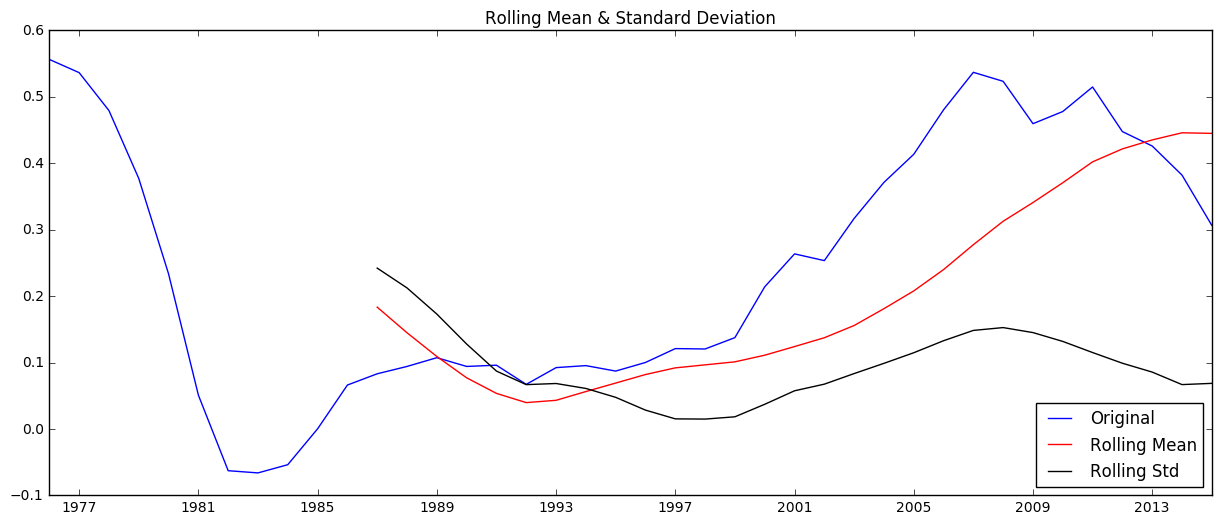

Results of Dickey-Fuller Test:
Test Statistic                 -2.665358
p-value                         0.080227
#Lags Used                     10.000000
Number of Observations Used    29.000000
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
Critical Value (1%)            -3.679060
dtype: float64


In [24]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

After using the above method, therer is now a 90% chance that the series is stationary. 

Now, I take the 'weighted moving average' where more recent values are given a higher weight. There can be many techniques to assign weights. A popular one is _exponentially weighted moving average_ where weights are assigned to all the previous values with a decay factor. This can be implemented in pandas as the following:

C:\Users\LYJ\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(adjust=True,ignore_na=False,halflife=0.05,min_periods=0).mean()
  if __name__ == '__main__':


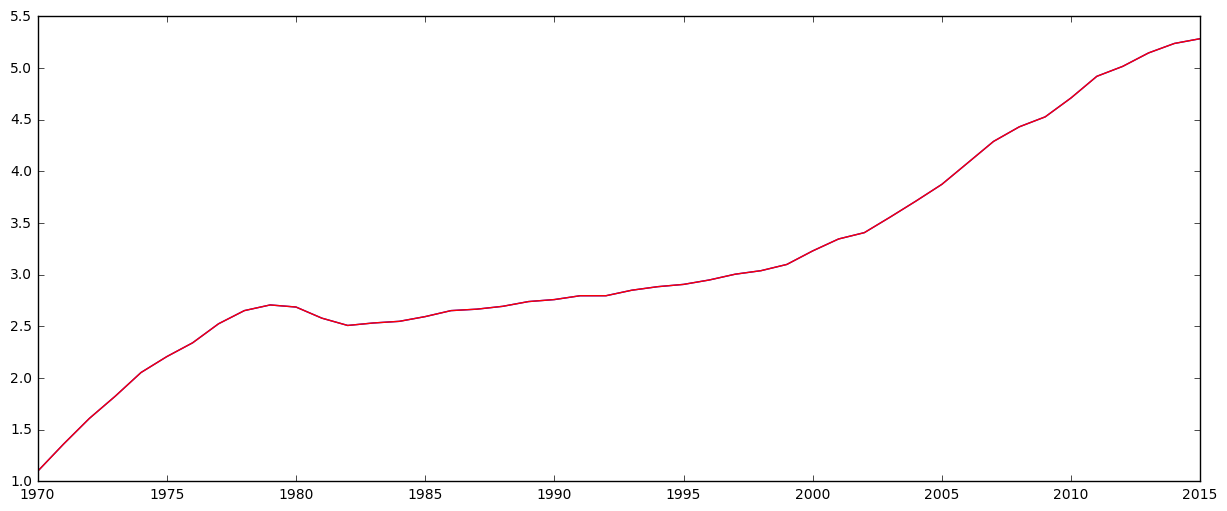

In [25]:
expwighted_avg = pd.ewma(ts_log, halflife=0.05) # tried 'halflife=5' at first and 
                                                # tried 'halflife=0.05' to get better results below
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

C:\Users\LYJ\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\LYJ\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


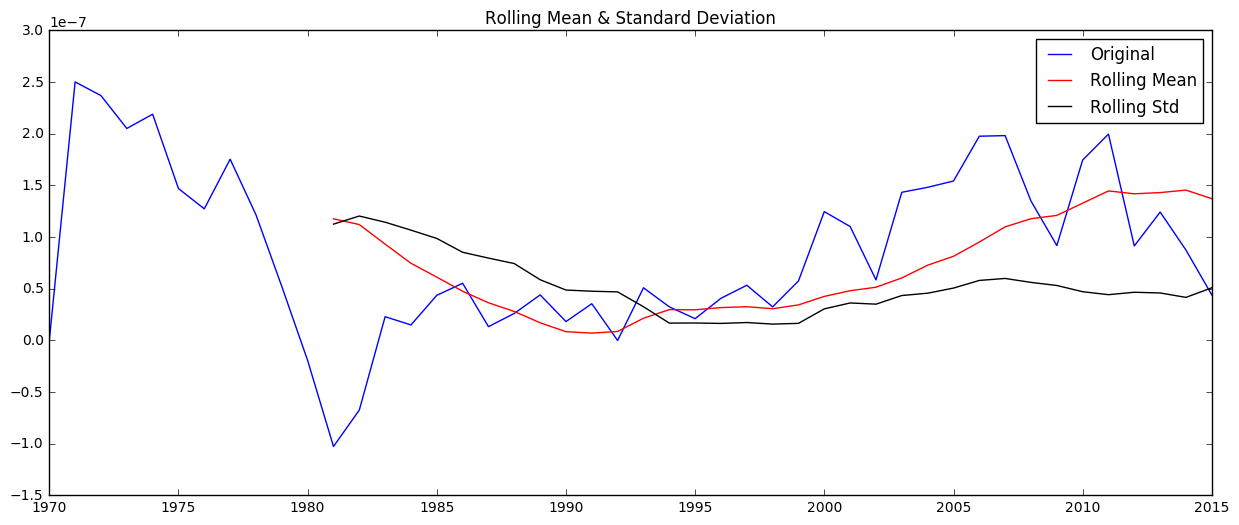

Results of Dickey-Fuller Test:
Test Statistic                 -2.700110
p-value                         0.074019
#Lags Used                      0.000000
Number of Observations Used    45.000000
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
Critical Value (1%)            -3.584829
dtype: float64


In [26]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

There is 90% chance that the series now is stationary. But, I still cannot say with 95% or 99% chance. Hence, I tried different ways to eliminate trend.

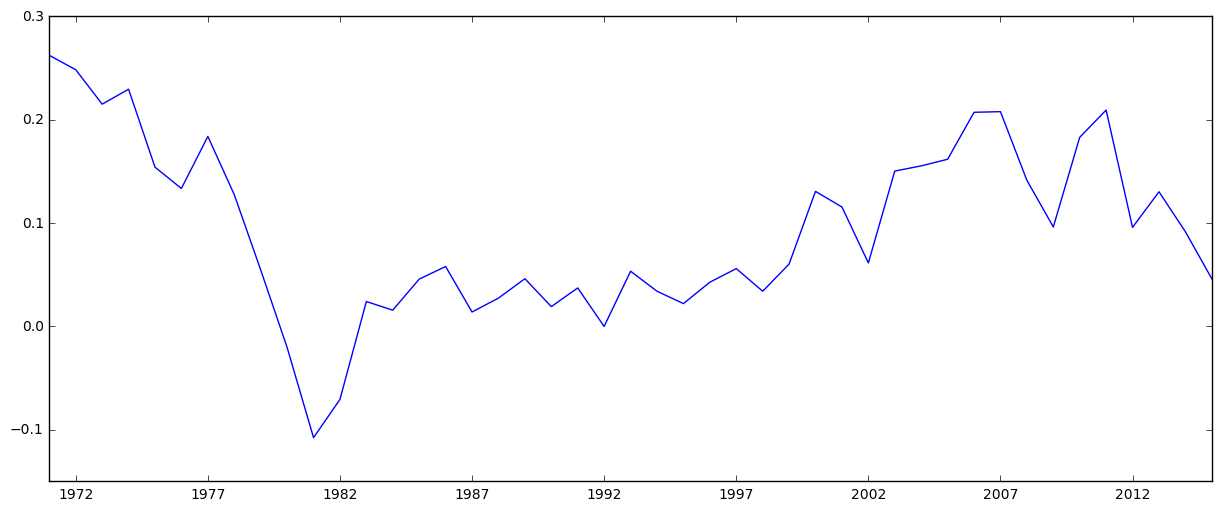

In [27]:
# Differencing (i.e. taking the difference with a particular time lag)
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

It seems this worked better to reduce the trend considerably.

C:\Users\LYJ\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\LYJ\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


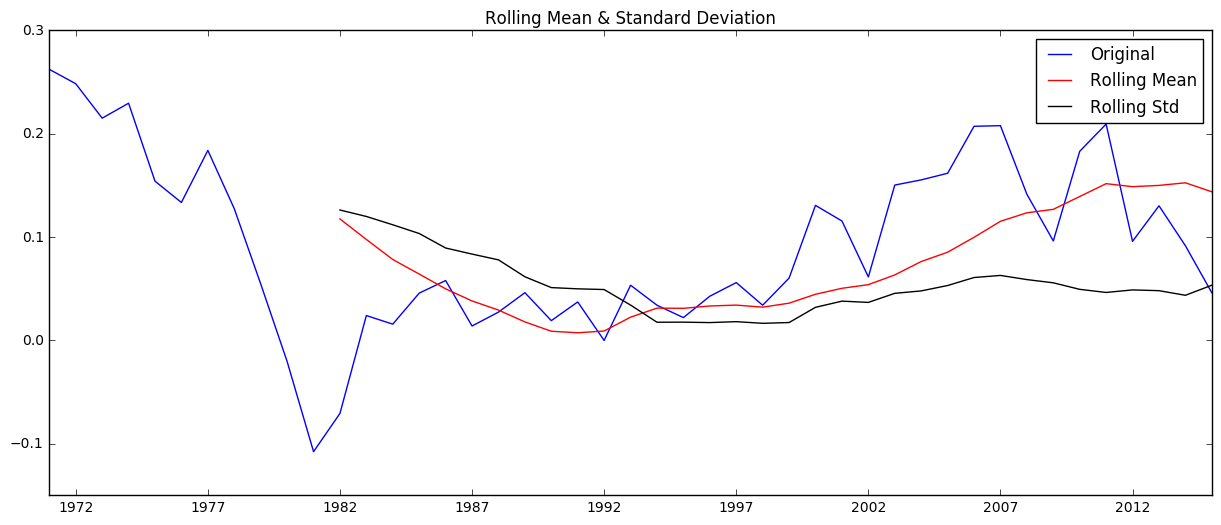

Results of Dickey-Fuller Test:
Test Statistic                 -2.154804
p-value                         0.223056
#Lags Used                      2.000000
Number of Observations Used    42.000000
Critical Value (5%)            -2.933297
Critical Value (10%)           -2.604991
Critical Value (1%)            -3.596636
dtype: float64


In [28]:
# let me verify that through Dickey-Fuller test
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

Test Statistic is greater than Critical Value. So, I still cannot reject the null hypothesis that the series is non-stationary. 

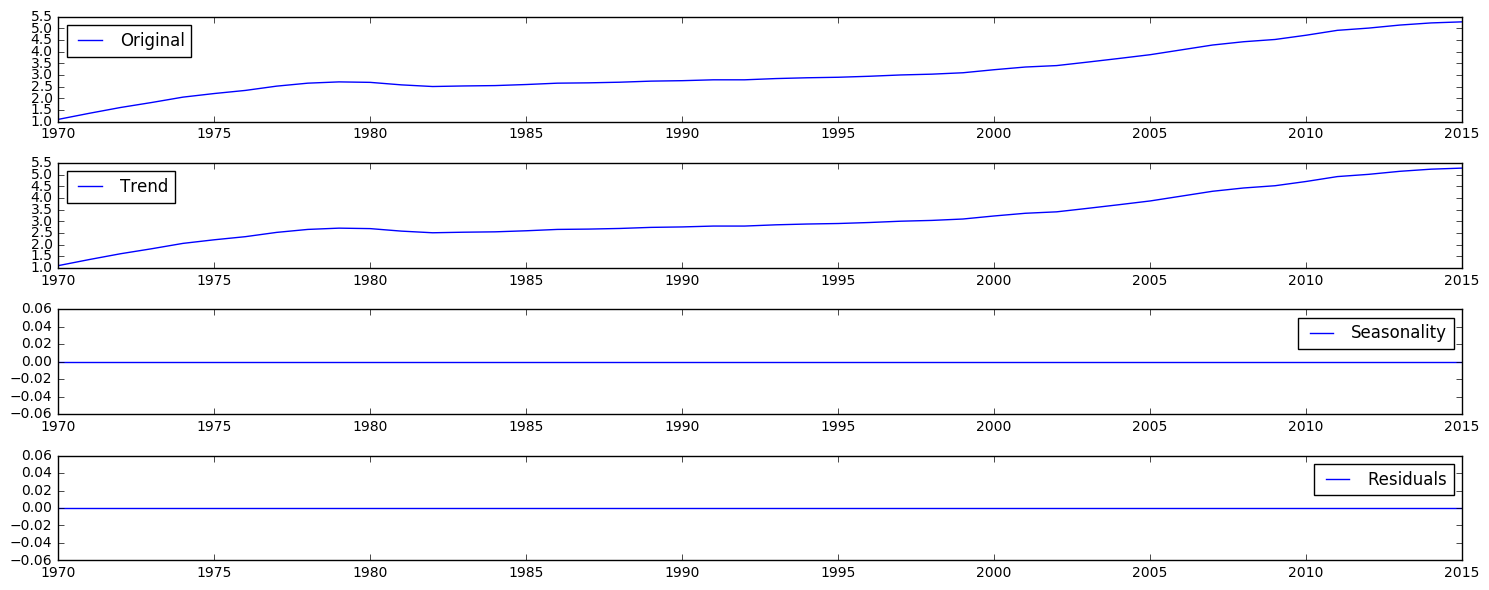

In [29]:
# Decomposing
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Upon doing decomposition, I see that there's no seasonality or residuals (see above).

C:\Users\LYJ\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\LYJ\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


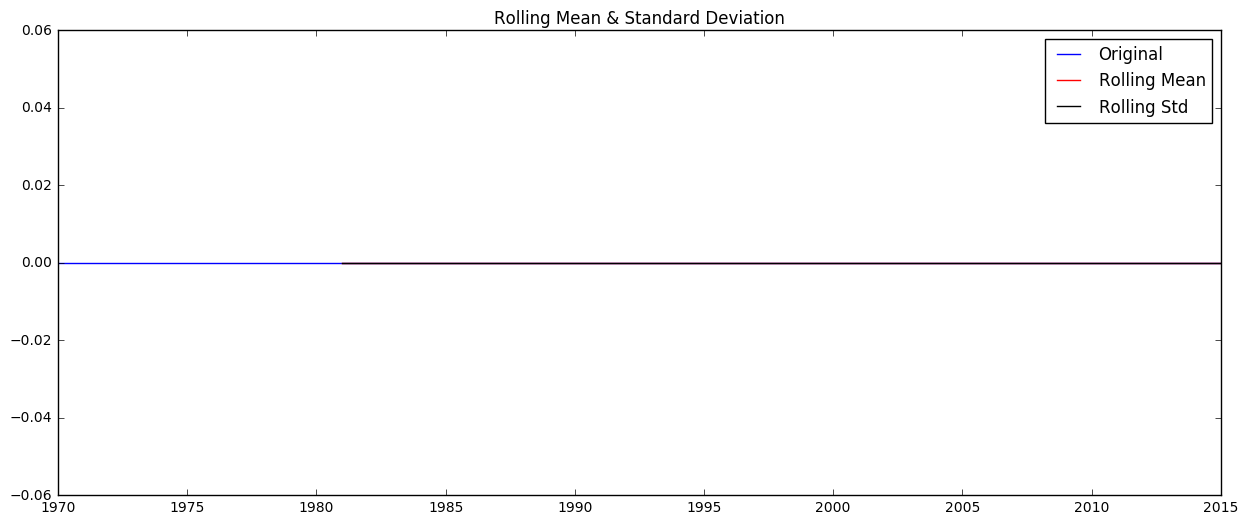

Results of Dickey-Fuller Test:
Test Statistic                       NaN
p-value                              NaN
#Lags Used                      0.000000
Number of Observations Used    45.000000
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
Critical Value (1%)            -3.584829
dtype: float64


In [30]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

Apparently, differencing or decomposing doe _NOT_ work any better than exponentially weighted moving average method above. So, I'll use **ts_log_ewma_diff**.

### Forecasting a Time Series

Having performed the trend and seasonality estimation techniques, there can be two situations:
- A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare.
- A series with significant dependence among values. In this case we need to use some statistical models like ARIMA to forecast the data.

In my case, it will be a series with significant dependence among values. Hence, I will use statistical models like ARIMA to forecast the data.

**Auto-Regressive Integrated Moving Averages (ARIMA)** forecasting for a stationary time series is a linear (like a linear regression) equation. The predictors depend on the parameters (p, d, q) of the ARIMA model:

1. **Number of AR (Auto-Regressive) terms (p)**: AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
2. **Number of MA (Moving Average) terms (q)**: MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
3. **Number of Differences (d)**: These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers.
1. **Autocorrelation Function (ACF)**: It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
2. **Partial Autocorrelation Function (PACF)**: This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

In [31]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [32]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

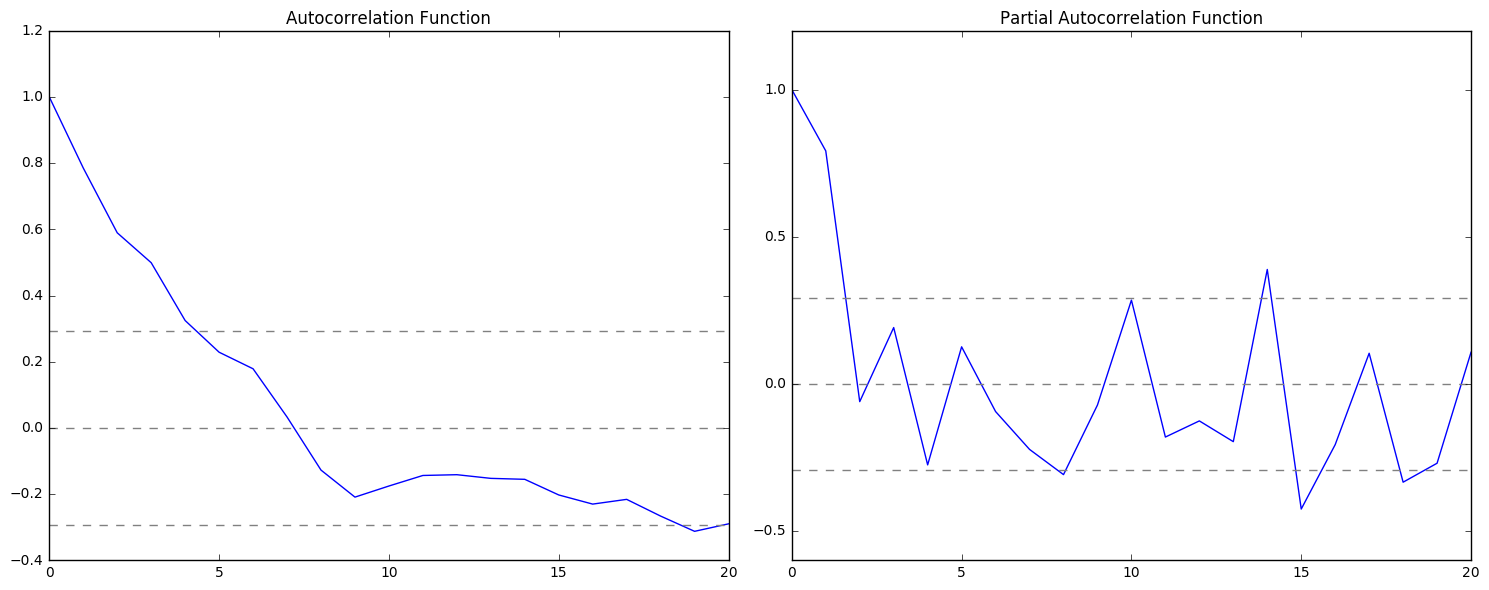

In [33]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:
1. **p** – The lag value where the **PACF** chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=3.
2. **q** – The lag value where the **ACF** chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=3.

Now, lets make 3 different ARIMA models considering individual as well as combined effects. I will also print the RSS for each. Please note that here RSS is for the values of residuals and not actual series.

In [34]:
# Load the ARIMA model
from statsmodels.tsa.arima_model import ARIMA

ARIMA model takes a tuple (p,d,q). Let's model the 3 cases:
1. **AR Model**: ARIMA(3, 1, 0)
2. **MA Model**: ARIMA(0, 1, 3)
3. **Combined Model**: ARIMA(3, 1, 3)

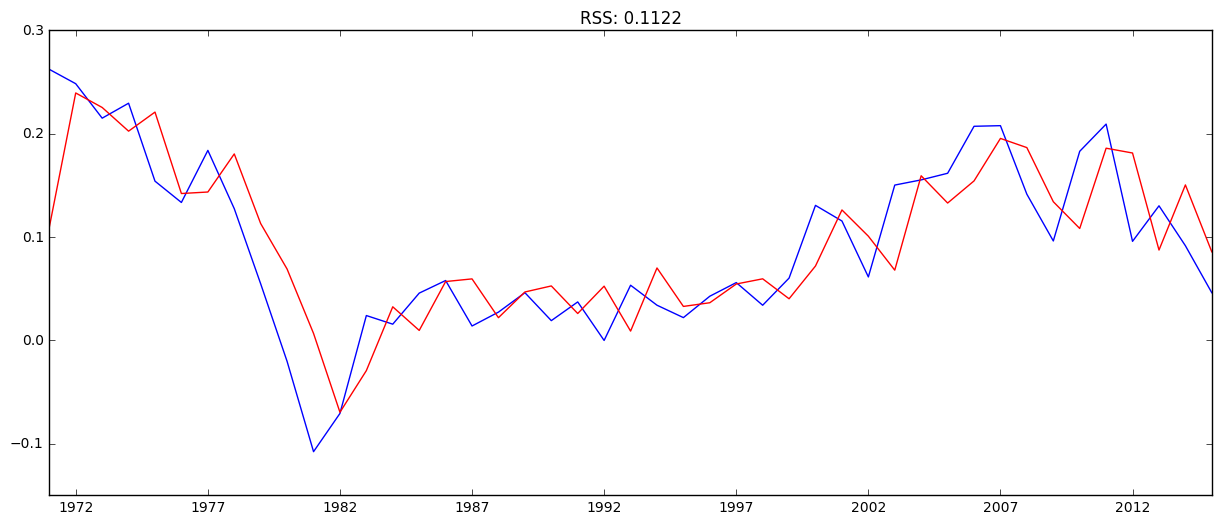

In [35]:
# AR model
model = ARIMA(ts_log, order=(3, 1, 0))  # order=(p, d, q)
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

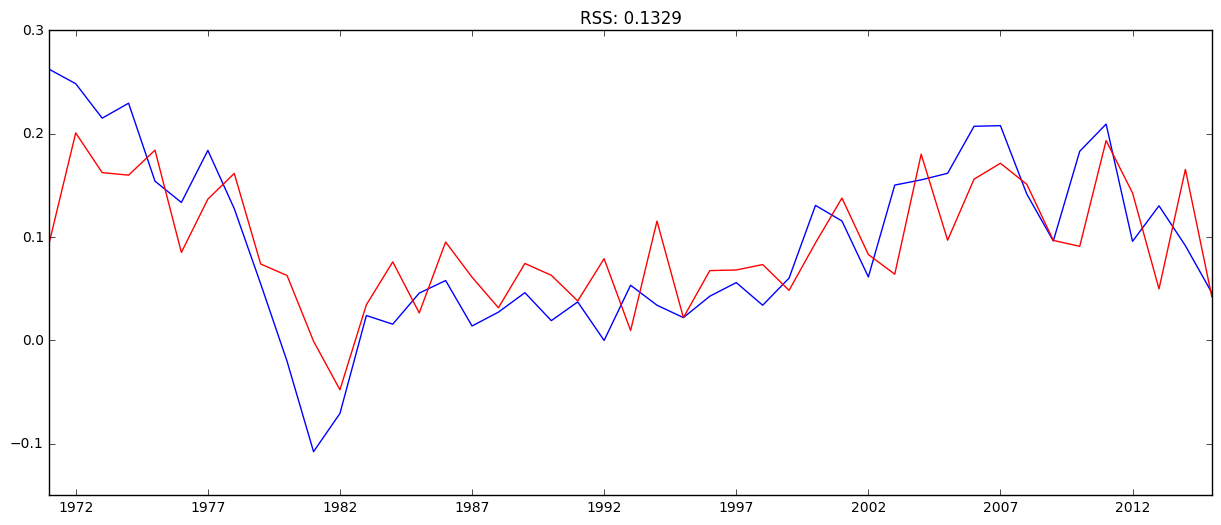

In [36]:
# MA model
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

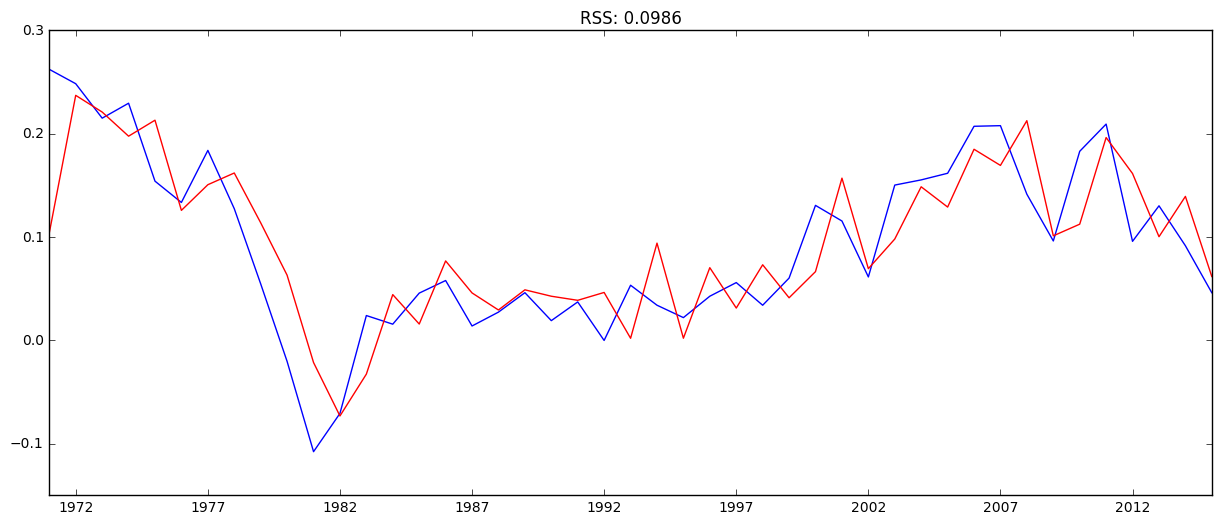

In [37]:
# Combined Model
model = ARIMA(ts_log, order=(3, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

Here we can see that the AR and MA models have similar RSS but combined is significantly better.

C:\Users\LYJ\Anaconda3\lib\site-packages\statsmodels\base\data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


2015-01-01    0.061858
2016-01-01    0.073484
2017-01-01    0.073189
2018-01-01    0.073659
2019-01-01    0.089949
2020-01-01    0.080028
2021-01-01    0.093776
2022-01-01    0.090833
2023-01-01    0.092809
2024-01-01    0.098672
2025-01-01    0.094187
2026-01-01    0.100798
2027-01-01    0.098307
2028-01-01    0.100090
2029-01-01    0.101913
2030-01-01    0.100085
Freq: AS-JAN, dtype: float64


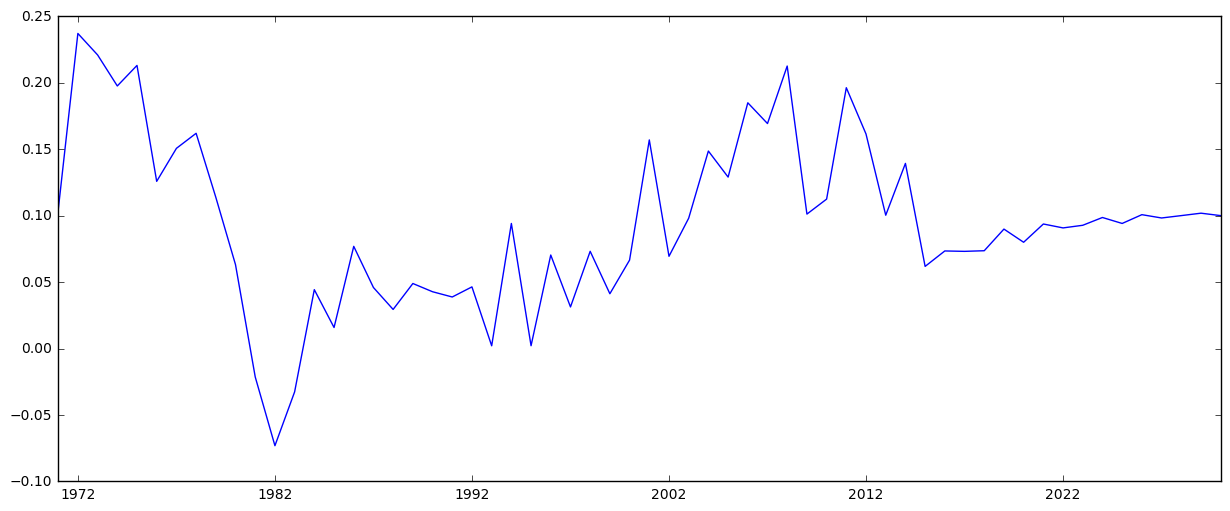

In [100]:
### 
#Something wrong with below codes?
# Now predict the gas consumption for next 15 years
start = len(ts)-45
end = len(ts)+14
y_forecast = results_ARIMA.predict(start, end)
print(y_forecast[-16:])
plt.plot(y_forecast)

#### Taking it back to original scale ####

Since the combined model gave best result, let's scale it back to the original values and see how well it performs there. First step would be to store the predicted results as a separate series and observe it.

In [38]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Year
1971-01-01    0.104123
1972-01-01    0.237192
1973-01-01    0.221019
1974-01-01    0.197678
1975-01-01    0.213136
dtype: float64


Notice that these start from '1971-01-01' and not the first year '1970-01-01'. This is because I took a lag by 1 and first element doesn't have anything before it to subtract from. The way to convert the differencing to log scale is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. The cumulative sum can be found as:

In [105]:
###
y_forecast_diff= pd.Series(y_forecast, copy=True)
print(y_forecast_diff.head())
y_forecast_diff_cumsum = y_forecast_diff.cumsum()
print(y_forecast_diff_cumsum[-20:])

1971-01-01    0.104123
1972-01-01    0.237192
1973-01-01    0.221019
1974-01-01    0.197678
1975-01-01    0.213136
Freq: AS-JAN, dtype: float64
2011-01-01    3.812486
2012-01-01    3.974031
2013-01-01    4.074422
2014-01-01    4.213811
2015-01-01    4.275670
2016-01-01    4.349154
2017-01-01    4.422343
2018-01-01    4.496002
2019-01-01    4.585950
2020-01-01    4.665979
2021-01-01    4.759754
2022-01-01    4.850587
2023-01-01    4.943396
2024-01-01    5.042067
2025-01-01    5.136254
2026-01-01    5.237053
2027-01-01    5.335360
2028-01-01    5.435450
2029-01-01    5.537363
2030-01-01    5.637448
Freq: AS-JAN, dtype: float64


In [39]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

Year
1971-01-01    0.104123
1972-01-01    0.341315
1973-01-01    0.562334
1974-01-01    0.760012
1975-01-01    0.973148
dtype: float64


Next I have to add them to base number. For this lets create a series with all values as base number and add the differences to it. This can be done as:

2015-01-01    215.784870
2016-01-01     77.412947
2017-01-01     83.291194
2018-01-01     89.657921
2019-01-01     98.096343
2020-01-01    106.269528
2021-01-01    116.717263
2022-01-01    127.815403
2023-01-01    140.245671
2024-01-01    154.789669
2025-01-01    170.077506
2026-01-01    188.114846
2027-01-01    207.547484
2028-01-01    229.396067
2029-01-01    254.007216
2030-01-01    280.745329
dtype: float64


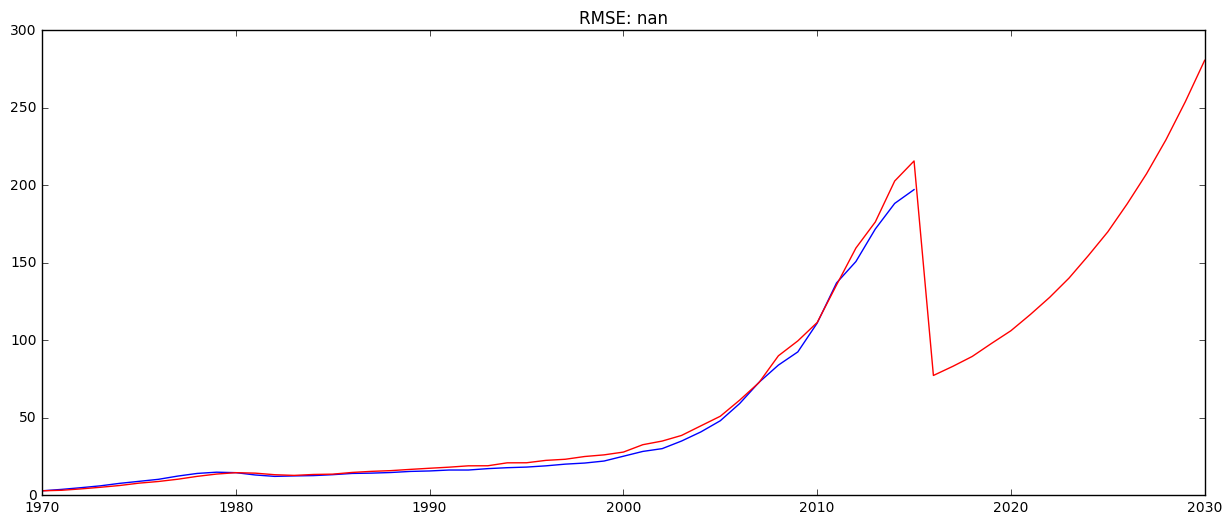

In [102]:
###
forecasts_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
forecasts_ARIMA_log = forecasts_ARIMA_log.add(y_forecast_diff_cumsum, fill_value=0)
#forecasts_ARIMA_log.head()
forecasts_ARIMA = np.exp(forecasts_ARIMA_log)
plt.plot(ts)
plt.plot(forecasts_ARIMA, 'red')
plt.title('RMSE: %.4f'% np.sqrt(sum((forecasts_ARIMA-ts)**2)/len(ts)))
print(forecasts_ARIMA[-16:])

In [40]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Year
1970-01-01    1.098612
1971-01-01    1.202735
1972-01-01    1.439928
1973-01-01    1.660946
1974-01-01    1.858624
dtype: float64

Here the first element is base number itself and from thereon the values cumulatively added. Last step is to take the exponent and compare with the original series.

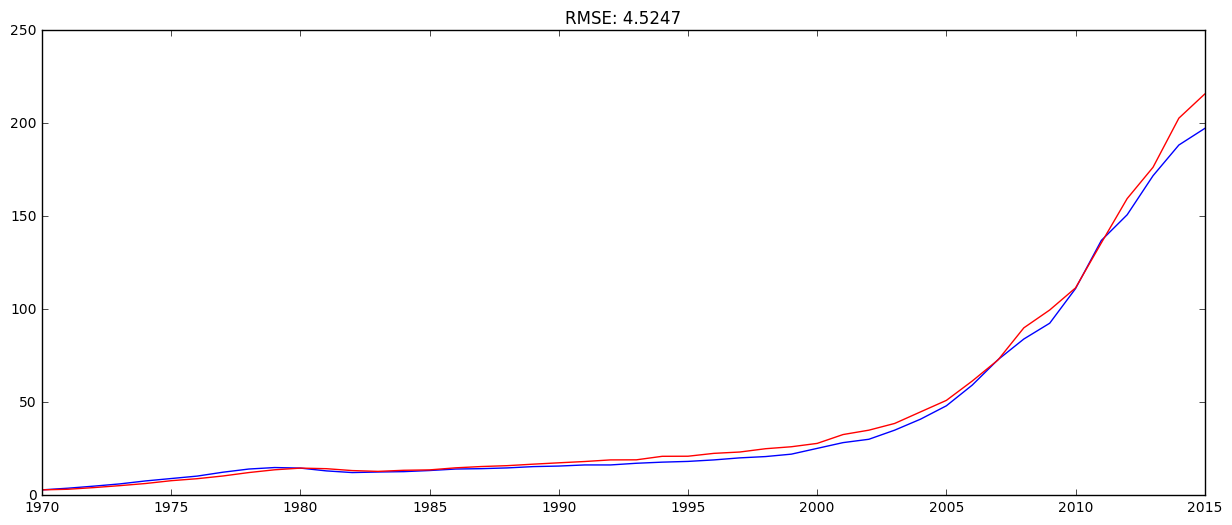

In [43]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA, 'red')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

Finally we have a forecast at the original scale.